In [28]:
# This code compares triple-for loop and flat von neimann neighbours implementations
# and tests if this 2 methods gives the same result
# also test that 460 instead of 512 on 0-axis

# firstly i remove this condition:
            # if ro[i, j, k] < 0.1 and i != A and j != B and k != C: # refl􏰂ecting condition | use numpy masking
                # P[i, j, k] = 0

import numpy as np
from time import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # 10 x 10 inches plot

In [59]:
N = 8
S = 6 # number of slices / CT-images / scans

r = np.random.random((S, N, N))
# r = np.load('r.npy')
ro  = 1e-5 + 1.24e-3*r - 2.83e-7*r*r + 2.79e-11*r*r*r
c = (ro + 0.112) * 1.38e-6

# тут не факт что все 1
l = 1 # dt
h = 1 # dx = dy = dz

K = l / h * c
K2 = K**2
K_2_by_3 = K**2 / 3
# K2_3_ro = K2 / 3 / ro


# initial conditions
P_pp = np.random.random((S, N, N)) # previous previous t - 2
P_p  = np.random.random((S, N, N)) # previous          t - 1
P    = np.random.random((S, N, N)) # current           t

# P_pp = np.arange(N**3).reshape(N, N, N) * 10.
# P_p = np.arange(N**3).reshape(N, N, N) * 12.
# P_pp = np.load('P_pp.npy')
# P_p = np.load('P_p.npy')
# P    = np.zeros((S, N, N), dtype=np.float64) # current           t

# np.save('P_pp.npy', P_pp)
# np.save('P_p.npy', P_p)
# np.save('r.npy', r)

In [60]:
def P_step(P_pp, P_p):
    '''
    mb work with flat and then reshape in return
    norm by now, mb add some more optimisations in future, also cuda
    '''

    S = P_p.shape[0]
    N = P_p.shape[1]

    P = 2 * P_p - P_pp
    Z = 22.5 * P_p
    

    cell_indeces_flat = np.arange(S * N * N).reshape(S, N, N)[2:-2, 2:-2, 2:-2].flatten().reshape(-1, 1) # vertical vector

    s1_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2])      # i±1 j±1 k±1 
    s2_indexes_flat = cell_indeces_flat + np.array([-1, 1, -N, N, -N**2, N**2]) * 2  # i±2 j±2 k±2 
    s1_values = P_p.flatten()[s1_indexes_flat] # each row contains 6 neighbors of cell 
    s2_values = P_p.flatten()[s2_indexes_flat] # each row contains 6 neighbors of cell 
    s1 = np.sum(s1_values, axis=1) # sum by axis=1 is faster for default order
    s2 = np.sum(s2_values, axis=1)

    Z[2:-2, 2:-2, 2:-2] -=   4 * s1.reshape(S-4, N-4, N-4)
    Z[2:-2, 2:-2, 2:-2] += 1/4 * s2.reshape(S-4, N-4, N-4)


    m1 = np.array([1, -1, -1/8, -1/8])
    m2 = np.array([1, -1])

    s3_V_indexes = cell_indeces_flat + np.array([N**2, -N**2, 2*N**2, -2*N**2])
    s3_V_values = P_p.flatten()[s3_V_indexes] * m1 # po idee mozhno za skobki kak to vinesti m1 i m2
    s3_V_sum = np.sum(s3_V_values, axis=1)
    s3_N_indexes = cell_indeces_flat + np.array([N**2, -N**2])
    s3_N_values = ro.flatten()[s3_N_indexes] * m2
    s3_N_sum = np.sum(s3_N_values, axis=1)
    s3 = (s3_V_sum / s3_N_sum).reshape(S-4, N-4, N-4)

    s4_V_indexes = cell_indeces_flat + np.array([N, -N, 2*N, -2*N])
    s4_V_values = P_p.flatten()[s4_V_indexes] * m1
    s4_V_sum = np.sum(s4_V_values, axis=1)
    s4_N_indexes = cell_indeces_flat + np.array([N, -N])
    s4_N_values = ro.flatten()[s4_N_indexes] * m2
    s4_N_sum = np.sum(s4_N_values, axis=1)
    s4 = (s4_V_sum / s4_N_sum).reshape(S-4, N-4, N-4)

    s5_V_indexes = cell_indeces_flat + np.array([1, -1, 2, -2])
    s5_V_values = P_p.flatten()[s5_V_indexes] * m1
    s5_V_sum = np.sum(s5_V_values, axis=1)
    s5_N_indexes = cell_indeces_flat + np.array([N, -N])
    s5_N_values = ro.flatten()[s5_N_indexes] * m2
    s5_N_sum = np.sum(s5_N_values, axis=1)
    s5 = (s5_V_sum / s5_N_sum).reshape(S-4, N-4, N-4)

    Z[2:-2, 2:-2, 2:-2] += (s3 + s4 + s5) * ro[2:-2, 2:-2, 2:-2]
    P -= Z * K_2_by_3
    P[ro < 0.1] = 0
#     return P[2:-2, 2:-2, 2:-2] # should return array of shape (S, N, N)
    return P

In [61]:
t0 = time()
P2 = P_step(P_pp, P_p)
t_P2 = time() - t0
print(t_P2)

0.0007650852203369141


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


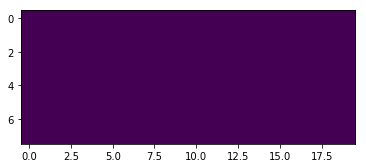

In [62]:
steps = 20
img = np.zeros((steps, N))
for i in range(steps):
    P_pp_new = P_p
    P_p_new  = P
    P_new = P_step(P_pp, P_p)
    
    print(P_new[3,3,3]) # print or save or send to visualisation method
    img[i] = P_new[-1, 3]


    P_pp = P_pp_new
    P_p  = P_p_new
    P    = P_new
plt.imshow(img.T)

---

---

---

# Test

In [ ]:
# A = np.array([1])
# B = np.array([1])
# C = np.array([1])
A, B, C = 1, 1, 1
print('A\tB\tC')
print(A, B, C, sep='\t')
for i in range(10):
    A_new = B
    B_new = C
    C_new = A + B
    print(A_new, B_new, C_new, sep='\t') # print or save or send to visualisation method
    
    A = A_new
    B = B_new
    C = C_new

# numpy masking for re􏰦flecting condition
re􏰦flecting condition (includes all boundaries):
$$\rho(\mathbf{x}, t) = 0 if 􏰩\rho(\mathbf{x}) < 0.1 g/cc, \mathbf{x} = [x, y, z]$$

In [46]:
rho = np.array([0.13, 0.2, 0.01, 0.4, 0.03, 0, 0.9])
p   = np.array([   1,   2,    3,   4,    5, 6,   7])

In [47]:
p[rho < 0.1]

array([3, 5, 6])

In [48]:
p[rho < 0.1] = 0